<a href="https://colab.research.google.com/github/BI-DS/EBA-3530/blob/main/Lecture_3/classification_spotify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification of songs in Spotify

Spotify assigns 13 different musical attributes/features to each song (see this [link](https://developer.spotify.com/console/get-audio-features-track/)). These song attributes, or features, are used to recommend new music to spotify's users. The features are mostly numerical values. Spotify also assigns a **popularity score** based on the total number of clicks for a given song. There is a copy of such a data in our repository. Alternatively, you can get a sample from [kaggle](https://www.kaggle.com/tomigelo/spotify-audio-features/home).

The question is: can we classify songs as "popular" based on their musical attributes?

In [2]:
# load libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import statsmodels.api as sm
# useful libraries for k-fold CV for cross-sectional data
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

useful wrapper for statsmodels

In [3]:
""" sklearn-style wrapper for statsmodels regressors """
from sklearn.base import BaseEstimator, RegressorMixin
class SMWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, model_class, fit_intercept=True):
        self.model_class = model_class
        self.fit_intercept = fit_intercept
    def fit(self, X, y):
        if self.fit_intercept:
            X = sm.add_constant(X)
        self.model_ = self.model_class(y, X)
        self.results_ = self.model_.fit(disp=0)
        return self
    def predict(self, X):
        if self.fit_intercept:
            X = sm.add_constant(X)
        return self.results_.predict(X)

1) Load the dataset

* 1.1) load the file `spotify.csv`from the folder Lecture_2 and assign the following column names to a `Pandas` dataframe:

    'artist', 'track_id', 'track_name', 'acousticness', 'danceability','duration_ms', 'energy', 'instrumentalness', 'key', 'liveness',    'loudness','mode', 'speechiness', 'tempo','time_signature', 'valence', 'popularity'


In [4]:
# @title 1.1) load csv into a dataframe

# this is the address where the data is at github
url='https://raw.githubusercontent.com/BI-DS/EBA-3530/main/Lecture_2/spotify.csv'

# load it into a data frame
col_names = ['artist', 'track_id', 'track_name', 'acousticness', 'danceability',
             'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness',
             'loudness','mode', 'speechiness', 'tempo', 'time_signature',
             'valence', 'popularity']

# read csv file
df = pd.read_csv(url, delimiter=',', names=col_names, header=1)
print('The data set has {} observations with {} features.'.\
      format(df.shape[0],df.shape[1]))

The data set has 130662 observations with 17 features.


## 2) Threshold on continous variables

We can convert any continous variable $y$ into a binary response by defining a **thershold** value. That is, if y > thershold then y = 1, else y = 0.

* 2.1) plot a normalized histogram of the vaariable `popularity` together with the threshold = 35

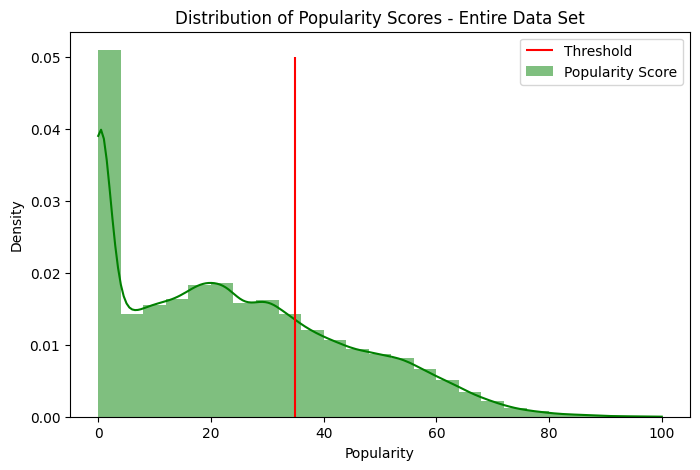

In [6]:
# @title 2.1) visualize histogram and thershold

# so lets definy a threhold for the popularity socre at spotify
threshold = 35

# I am defining a function to plot a density function
def plot_density(df, thershold):
    # set palette
    sns.set_palette('muted')

    # create initial figure
    fig = plt.figure(figsize=(8,5))
    ax = fig.add_subplot(111)

    # plot density
    sns.histplot(df['popularity'], color='g', label="Popularity Score",\
                 kde=True, stat="density", linewidth=0, bins=25)\
               .set_title("Distribution of Popularity Scores - Entire Data Set")
    # plot the threshold
    plt.vlines(threshold, 0, 0.05, colors='r', label='Threshold')

    # create x and y axis labels
    plt.xlabel("Popularity")
    plt.ylabel("Density")
    plt.legend()

    plt.show()

# plot the score density together with
# the threshold
plot_density(df, threshold)

## 3) K-fold cross-validation
The idea here is to use the thersehold on the (continous) `popularity` score to derive a binary response variable $y$. Then, using the song features, we classify songs into *popular* or *not popular* using a K-fold cross-validation approach.

* 3.1) create a variable called `pop_bib` with equals 1 if `popularity` > threshold, else equals 0

In [8]:
# @title 3.1) binary variable

# define binary variable
df['pop_bin'] = np.where(df['popularity'] > threshold, 1, 0)

* 3.2) Run a 5, 10, 15, 20 cross-validation for a logistic regression model in `statsmodels` and calculate the `AUC` score for each cross-validation. Use these feature variables as predictiors: 'acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'mode', 'speechiness','tempo', 'time_signature', 'valence'

In [11]:
# @title 3.2) cross-validation

# features to use as predictors/covariates
x = ['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness'
     ,'liveness','loudness','mode','speechiness','tempo','time_signature',\
     'valence']
y = ['pop_bin']

# get x and y
x = df[x].values
y = df[y].values

# define different number of folds
Ks = [5,10,15,20]
# lets iterate for each fold
for k in Ks:
  # indices for the k-folds
  kfolds = KFold(n_splits=k, shuffle=True)
  # define the model in statsmodels
  logistic_regression = sm.Logit
  #use the cross_val_score function to fit K models
  scores = cross_val_score(SMWrapper(logistic_regression), x, y, cv=kfolds,\
                           scoring='roc_auc')
  print('CV with {0} folds has an average AUC {1:.6f} with standard deviation {2:.4f}'.format(k,np.mean(scores),np.std(scores)))


CV with 5 folds has an average AUC 0.685828 with standard deviation 0.0048
CV with 10 folds has an average AUC 0.685747 with standard deviation 0.0044
CV with 15 folds has an average AUC 0.685783 with standard deviation 0.0065
CV with 20 folds has an average AUC 0.685751 with standard deviation 0.0051


$\color{red}{\textbf{Question:}}$ Add a loop at the top of the above block where you can use different threshold values and repeat the cross validation.

$\color{red}{\textbf{Tips:}}$  It can be a good idea to start with these two lines:

```
thresholds =[25, 35, 45, 55]
for threshold in thresholds:
```